# EE258 Project

Dataset : https://www.kaggle.com/crowww/a-large-scale-fish-dataset

Code References : https://www.tensorflow.org/tutorials/load_data/images

### Problem
The problem we hope to solve is creating an image classification model able to identify different types of fish or seafood at local supermarkets. The model will be able to identify at least 6 different classes of fish or seafood, with all other classes considered as "other".

In [1]:
pwd

'c:\\Users\\a1351\\ml\\EE258 Project'

In [2]:
# handle imports

import cv2
import os, glob
import matplotlib.pylab as plt
from os import listdir, makedirs
from os.path import isfile, join
import pandas as pd
import PIL
import numpy as np
from imageio import imread
import io
import pathlib
# from numba import jit, cuda

In [3]:
import tensorflow as tf
from tensorflow import keras
print("Tensorflow Version:",tf.__version__)
print("Keras Version:",keras.__version__)

Tensorflow Version: 2.7.0
Keras Version: 2.7.0


### Dataset

In [4]:
path = 'C:/Users/a1351/ml/Fish_Dataset_6'

# path = 'C:/Users/a1351/ml/Fish_Dataset'
data_dir = pathlib.Path(path)

image_count = len(list(data_dir.glob('**/*.png')))
print(image_count)

9000


The dataset is a total of 9000 445x590 pixel color images of fish with 1000 images per class. The dataset has been augmented per class with photo at different angles, rotated to generate 1000 data points per class. 

In [5]:
batch_size = 32
img_height = 445
img_width = 590

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height , img_width),
    batch_size = batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height , img_width),
    batch_size = batch_size
)

Found 9000 files belonging to 6 classes.
Using 7200 files for training.
Found 9000 files belonging to 6 classes.
Using 1800 files for validation.


In [6]:
class_names = train_ds.class_names
for name in class_names:
    print(name)


Black Sea Sprat
Bream
Mullet
Other
Shrimp
Trout


Found 9000 files belonging to 6 classes.
[1000. 2000. 2000. 2000. 1000. 1000.]


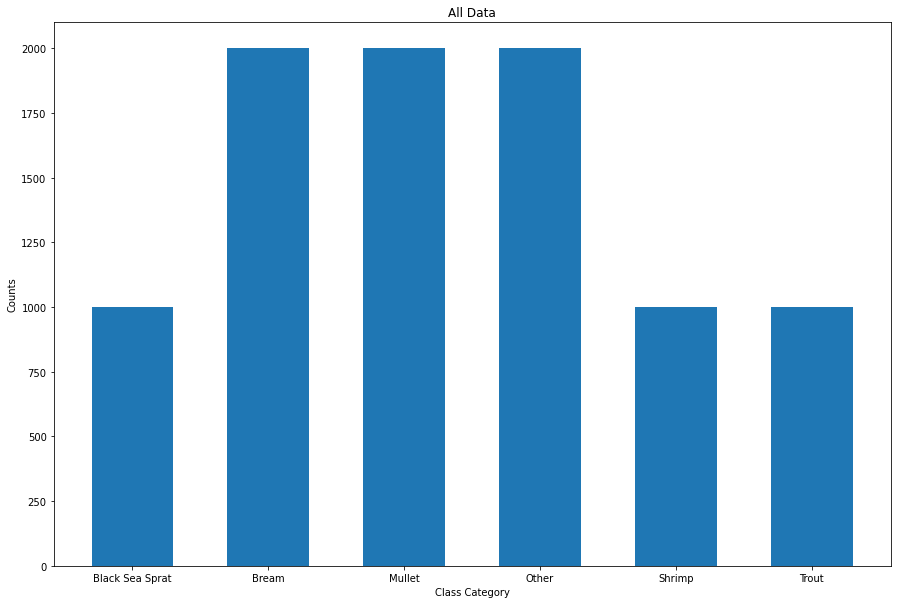

In [7]:
class_counts = np.zeros(len(class_names))
i = 0

all_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size = (img_height , img_width),
    seed=123
)

for all_img, all_labels in all_data:
    for cat in all_labels:
        class_counts[cat]+=1

print(class_counts)
plt.figure(figsize=(15,10))
distribution_data = dict(zip(class_names,class_counts))
plt.bar(list(distribution_data.keys()),distribution_data.values(),width =0.6)
plt.title('All Data')
plt.xlabel('Class Category')
plt.ylabel('Counts')
plt.show()


#### Outliers

Originally, the dataset provided 2000 images per class. 1000 images were rgb photos of the fish at different angles, augmented by rotating the images around. The other 1000 images per class were black and white photos of the fish outline. These outline images were removed from the dataset resulting in the useful dataset of 9000 rbg images, with 1000 images per class.

### Visualization of Dataset

Below is visualization of each unique class of the dataset and respective class name. Rotated photos illustrate data augmentation done on original photos.

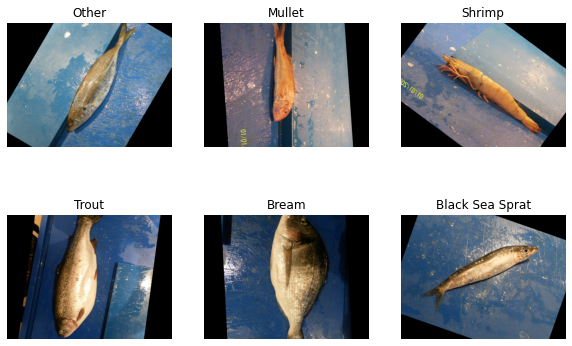

In [8]:
unique = []
i=0
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for item in range(len(labels)):
        if labels[item] in unique:
            continue
        else:
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[item].numpy().astype("uint8"))
            plt.title(class_names[labels[item]])
            plt.axis("off")

            i+=1
            unique.append(labels[item])
        
    break # run only once through a batch

In [9]:
## Reuse model from HW5

alt_model = keras.models.Sequential([
    # tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 8, strides=2, kernel_regularizer='l2', activation="relu",input_shape=[445,590,3]),
    tf.keras.layers.MaxPool2D(2),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

## compile the basic model

sgd = keras.optimizers.SGD(learning_rate=0.001)
alt_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
              metrics=["accuracy"])



In [10]:

history = alt_model.fit(
                    train_ds,
                    batch_size=32, 
                    epochs=50,
                    validation_data =test_ds,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 25s 103ms/step - loss: 653.9143 - accuracy: 0.6997 - val_loss: 442.4678 - val_accuracy: 0.9272
Epoch 2/50
225/225 [==============================] - 23s 103ms/step - loss: 440.5361 - accuracy: 0.9424 - val_loss: 438.5332 - val_accuracy: 0.9578
Epoch 3/50
225/225 [==============================] - 23s 102ms/step - loss: 436.4470 - accuracy: 0.9785 - val_loss: 434.4395 - val_accuracy: 0.9872
Epoch 4/50
225/225 [==============================] - 23s 102ms/step - loss: 432.5055 - accuracy: 0.9815 - val_loss: 430.5522 - val_accuracy: 0.9800
Epoch 5/50
225/225 [==============================] - 23s 102ms/step - loss: 428.6150 - accuracy: 0.9879 - val_loss: 426.6795 - val_accuracy: 0.9906
Epoch 6/50
225/225 [==============================] - 23s 103ms/step - loss: 424.7617 - accuracy: 0.9943 - val_loss: 422.8450 - val_accuracy: 0.9939
Epoch 7/50
225/225 [==============================] - 23s 102ms/step - loss: 420.9468 - accuracy: 0.9962 -

In [11]:
alt_model.save('baseline_model_6class.h5')

In [12]:
two_dense_model = keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 8, strides=2, activation="relu", input_shape=[445,590,3]),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

two_dense_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
                        metrics=["accuracy"])

In [13]:
history_two_dense_model = two_dense_model.fit(
                                        train_ds,
                                        batch_size=32,
                                        epochs=50,
                                        validation_data = test_ds,
                                        callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 23s 102ms/step - loss: 1097.8518 - accuracy: 0.2401 - val_loss: 1.7749 - val_accuracy: 0.2267
Epoch 2/50
225/225 [==============================] - 23s 102ms/step - loss: 1.7772 - accuracy: 0.2454 - val_loss: 1.7758 - val_accuracy: 0.2439
Epoch 3/50
225/225 [==============================] - 23s 103ms/step - loss: 1.7579 - accuracy: 0.2717 - val_loss: 1.7603 - val_accuracy: 0.2789
Epoch 4/50
225/225 [==============================] - 23s 103ms/step - loss: 1.7520 - accuracy: 0.2617 - val_loss: 1.7557 - val_accuracy: 0.2456
Epoch 5/50
225/225 [==============================] - 24s 105ms/step - loss: 2.7901 - accuracy: 0.2519 - val_loss: 1.7577 - val_accuracy: 0.2456


In [14]:
dropout_model = keras.models.Sequential([
    # tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 8, strides=2, activation="relu", input_shape=[445,590,3]),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

dropout_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
                    metrics=["accuracy"])


In [15]:
history_dropout = dropout_model.fit(
                                train_ds,
                                batch_size=32,
                                epochs=50,
                                validation_data = test_ds,
                                callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 25s 110ms/step - loss: 147.5113 - accuracy: 0.7051 - val_loss: 0.3087 - val_accuracy: 0.8928
Epoch 2/50
225/225 [==============================] - 25s 110ms/step - loss: 0.2136 - accuracy: 0.9344 - val_loss: 0.1231 - val_accuracy: 0.9644
Epoch 3/50
225/225 [==============================] - 25s 108ms/step - loss: 0.1086 - accuracy: 0.9681 - val_loss: 0.0847 - val_accuracy: 0.9789
Epoch 4/50
225/225 [==============================] - 25s 110ms/step - loss: 0.0746 - accuracy: 0.9790 - val_loss: 0.0610 - val_accuracy: 0.9872
Epoch 5/50
225/225 [==============================] - 25s 109ms/step - loss: 0.0536 - accuracy: 0.9856 - val_loss: 0.0473 - val_accuracy: 0.9861
Epoch 6/50
225/225 [==============================] - 24s 107ms/step - loss: 0.0429 - accuracy: 0.9878 - val_loss: 0.0397 - val_accuracy: 0.9872
Epoch 7/50
225/225 [==============================] - 24s 108ms/step - loss: 0.0322 - accuracy: 0.9915 - val_loss: 0.0357 - val_

In [16]:
rescaling_model = keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 8, strides=2, activation="relu", input_shape=[445,590,3]),
    tf.keras.layers.MaxPool2D(2),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

rescaling_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
                    metrics=["accuracy"])


In [17]:
history_rescaling = rescaling_model.fit(
                                train_ds,
                                batch_size=32,
                                epochs=50,
                                validation_data = test_ds,
                                callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 24s 104ms/step - loss: 1.4403 - accuracy: 0.4129 - val_loss: 1.0852 - val_accuracy: 0.5883
Epoch 2/50
225/225 [==============================] - 23s 103ms/step - loss: 1.0544 - accuracy: 0.6015 - val_loss: 1.0684 - val_accuracy: 0.5472
Epoch 3/50
225/225 [==============================] - 23s 103ms/step - loss: 0.8907 - accuracy: 0.6628 - val_loss: 0.8294 - val_accuracy: 0.6744
Epoch 4/50
225/225 [==============================] - 23s 103ms/step - loss: 0.7661 - accuracy: 0.7240 - val_loss: 0.8265 - val_accuracy: 0.6511
Epoch 5/50
225/225 [==============================] - 23s 103ms/step - loss: 0.6795 - accuracy: 0.7540 - val_loss: 0.6015 - val_accuracy: 0.7972
Epoch 6/50
225/225 [==============================] - 23s 104ms/step - loss: 0.5896 - accuracy: 0.7933 - val_loss: 0.5348 - val_accuracy: 0.8294
Epoch 7/50
225/225 [==============================] - 24s 106ms/step - loss: 0.5387 - accuracy: 0.8078 - val_loss: 0.4909 - val_ac

In [30]:
def create_model():
    alt_model = keras.models.Sequential([
    # tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 8, strides=2, kernel_regularizer='l2', activation="relu", input_shape=[445,590,3]),
    tf.keras.layers.MaxPool2D(2),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

    ## compile the basic model

    sgd = keras.optimizers.SGD(learning_rate=0.001)
    alt_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
              metrics=["accuracy"])
    return alt_model

In [31]:
model1 = create_model()
model2 = create_model()
model3 = create_model()
model4 = create_model()
model5 = create_model()

In [32]:
hold1 = all_data.shard(num_shards=5, index=0)
hold2 = all_data.shard(num_shards=5, index=1)
hold3 = all_data.shard(num_shards=5, index=2)
hold4 = all_data.shard(num_shards=5, index=3)
hold5 = all_data.shard(num_shards=5, index=4)

train1 = hold2.concatenate(hold3)
train1 = train1.concatenate(hold4)
train1 = train1.concatenate(hold5)

train2 = hold3.concatenate(hold4)
train2 = train2.concatenate(hold5)
train2 = train2.concatenate(hold1)

train3 = hold4.concatenate(hold5)
train3 = train3.concatenate(hold1)
train3 = train3.concatenate(hold2)

train4 = hold5.concatenate(hold1)
train4 = train4.concatenate(hold2)
train4 = train4.concatenate(hold3)

train5 = hold1.concatenate(hold2)
train5 = train5.concatenate(hold3)
train5 = train5.concatenate(hold4)


In [33]:
history1 = model1.fit(
                    train1,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 73s 325ms/step - loss: 1624.9932 - accuracy: 0.6204 - val_loss: 1276.8728 - val_accuracy: 0.8734
Epoch 2/50
225/225 [==============================] - 71s 317ms/step - loss: 1271.0077 - accuracy: 0.9270 - val_loss: 1265.1416 - val_accuracy: 0.9704
Epoch 3/50
225/225 [==============================] - 74s 327ms/step - loss: 1260.4940 - accuracy: 0.8740 - val_loss: 1254.2620 - val_accuracy: 0.8421
Epoch 4/50
225/225 [==============================] - 73s 324ms/step - loss: 1248.4274 - accuracy: 0.9167 - val_loss: 1242.6632 - val_accuracy: 0.9523


In [34]:
history2 = model2.fit(
                    train2,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 73s 323ms/step - loss: 4841237.5000 - accuracy: 0.2118 - val_loss: 4725040.5000 - val_accuracy: 0.2300
Epoch 2/50
225/225 [==============================] - 73s 325ms/step - loss: 4703935.5000 - accuracy: 0.2206 - val_loss: 4682704.0000 - val_accuracy: 0.2294
Epoch 3/50
225/225 [==============================] - 74s 329ms/step - loss: 4661790.0000 - accuracy: 0.2318 - val_loss: 4640752.0000 - val_accuracy: 0.2322
Epoch 4/50
225/225 [==============================] - 72s 318ms/step - loss: 4620022.0000 - accuracy: 0.2174 - val_loss: 4599169.0000 - val_accuracy: 0.2306
Epoch 5/50
225/225 [==============================] - 70s 312ms/step - loss: 4578628.0000 - accuracy: 0.2208 - val_loss: 4557966.5000 - val_accuracy: 0.2133


In [35]:
history3 = model3.fit(
                    train3,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold3,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
226/226 [==============================] - 70s 311ms/step - loss: 395.5612 - accuracy: 0.5562 - val_loss: 172.3901 - val_accuracy: 0.7260
Epoch 2/50
226/226 [==============================] - 70s 310ms/step - loss: 171.3705 - accuracy: 0.8112 - val_loss: 170.3950 - val_accuracy: 0.8906
Epoch 3/50
226/226 [==============================] - 71s 315ms/step - loss: 169.6188 - accuracy: 0.9019 - val_loss: 168.7281 - val_accuracy: 0.9280
Epoch 4/50
226/226 [==============================] - 75s 330ms/step - loss: 167.9334 - accuracy: 0.9358 - val_loss: 167.1407 - val_accuracy: 0.9515
Epoch 5/50
226/226 [==============================] - 73s 323ms/step - loss: 166.3682 - accuracy: 0.9585 - val_loss: 165.5992 - val_accuracy: 0.9676
Epoch 6/50
226/226 [==============================] - 74s 326ms/step - loss: 164.8275 - accuracy: 0.9745 - val_loss: 164.1309 - val_accuracy: 0.9738
Epoch 7/50
226/226 [==============================] - 71s 314ms/step - loss: 163.3290 - accuracy: 0.9818 -

In [36]:
history4 = model4.fit(
                    train4,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold4,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
226/226 [==============================] - 73s 323ms/step - loss: 2540.7056 - accuracy: 0.7120 - val_loss: 1529.2994 - val_accuracy: 0.9102
Epoch 2/50
226/226 [==============================] - 73s 322ms/step - loss: 1522.3021 - accuracy: 0.9581 - val_loss: 1515.3075 - val_accuracy: 0.9794
Epoch 3/50
226/226 [==============================] - 72s 320ms/step - loss: 1508.5129 - accuracy: 0.9788 - val_loss: 1501.7482 - val_accuracy: 0.9682
Epoch 4/50
226/226 [==============================] - 73s 322ms/step - loss: 1494.9407 - accuracy: 0.9814 - val_loss: 1488.1230 - val_accuracy: 0.9849
Epoch 5/50
226/226 [==============================] - 73s 321ms/step - loss: 1481.4572 - accuracy: 0.9847 - val_loss: 1474.7250 - val_accuracy: 0.9872
Epoch 6/50
226/226 [==============================] - 72s 320ms/step - loss: 1468.1161 - accuracy: 0.9878 - val_loss: 1461.4393 - val_accuracy: 0.9955
Epoch 7/50
226/226 [==============================] - 72s 320ms/step - loss: 1454.8914 - accur

In [37]:
history5 = model5.fit(
                    train5,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold5,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
226/226 [==============================] - 73s 323ms/step - loss: 2308.4863 - accuracy: 0.7311 - val_loss: 1748.7061 - val_accuracy: 0.9035
Epoch 2/50
226/226 [==============================] - 74s 329ms/step - loss: 1740.7550 - accuracy: 0.9464 - val_loss: 1732.8510 - val_accuracy: 0.9481
Epoch 3/50
226/226 [==============================] - 73s 323ms/step - loss: 1725.0161 - accuracy: 0.9711 - val_loss: 1717.1621 - val_accuracy: 0.9816
Epoch 4/50
226/226 [==============================] - 71s 315ms/step - loss: 1709.4780 - accuracy: 0.9739 - val_loss: 1701.7006 - val_accuracy: 0.9838
Epoch 5/50
226/226 [==============================] - 72s 318ms/step - loss: 1694.0695 - accuracy: 0.9838 - val_loss: 1686.4127 - val_accuracy: 0.9816
Epoch 6/50
226/226 [==============================] - 72s 319ms/step - loss: 1678.8083 - accuracy: 0.9883 - val_loss: 1671.1925 - val_accuracy: 0.9911
Epoch 7/50
226/226 [==============================] - 72s 321ms/step - loss: 1663.6879 - accur

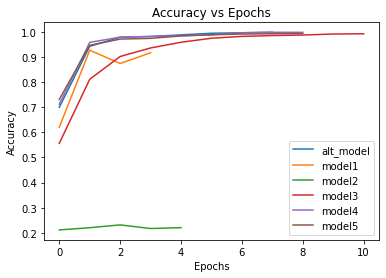

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.plot(history4.history['accuracy'])
plt.plot(history5.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(['alt_model','model1','model2','model3','model4','model5'])

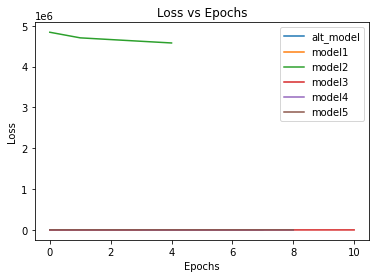

In [39]:
plt.plot(history.history['loss'])
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.plot(history4.history['loss'])
plt.plot(history5.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(['alt_model','model1','model2','model3','model4','model5'])

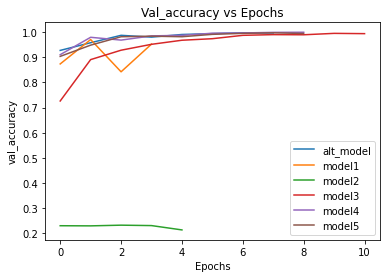

In [40]:
plt.plot(history.history['val_accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('val_accuracy')
plt.title('Val_accuracy vs Epochs')
plt.legend(['alt_model','model1','model2','model3','model4','model5'])

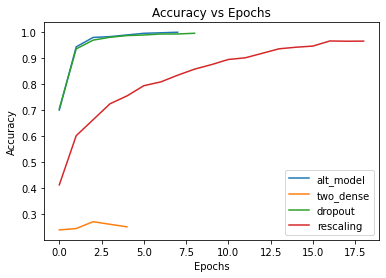

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history_two_dense_model.history['accuracy'])
plt.plot(history_dropout.history['accuracy'])
plt.plot(history_rescaling.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(['alt_model','two_dense','dropout','rescaling'])

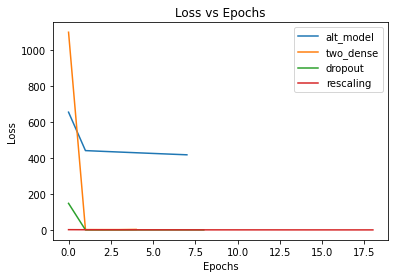

In [42]:
plt.plot(history.history['loss'])
plt.plot(history_two_dense_model.history['loss'])
plt.plot(history_dropout.history['loss'])
plt.plot(history_rescaling.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(['alt_model','two_dense','dropout','rescaling'])

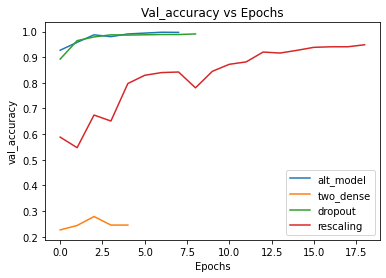

In [43]:
plt.plot(history.history['val_accuracy'])
plt.plot(history_two_dense_model.history['val_accuracy'])
plt.plot(history_dropout.history['val_accuracy'])
plt.plot(history_rescaling.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('val_accuracy')
plt.title('Val_accuracy vs Epochs')
plt.legend(['alt_model','two_dense','dropout','rescaling'])

In [127]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [97]:
test_labels = np.array([])
for images, labels in test_ds:
    for item in range(len(labels)):
        test_labels = np.append(test_labels,labels[item])

tf.Tensor([1 5 0 4 0 4 5 1 3 1 2 1 1 2 3 3 1 1 0 5 0 3 4 3 1 5 1 4 2 3 2 1], shape=(32,), dtype=int32)
tf.Tensor([3 4 0 3 4 2 5 1 0 4 3 3 1 0 1 5 2 2 3 3 2 4 1 2 1 1 0 3 1 0 3 5], shape=(32,), dtype=int32)
tf.Tensor([4 2 2 2 4 2 3 1 1 3 3 3 2 2 1 0 2 3 0 5 1 0 2 1 5 1 5 2 0 0 2 2], shape=(32,), dtype=int32)
tf.Tensor([3 3 1 2 5 0 1 1 1 5 3 0 1 5 4 1 3 2 3 3 0 3 2 1 1 5 1 5 2 1 2 1], shape=(32,), dtype=int32)
tf.Tensor([5 2 2 1 5 3 5 1 3 1 3 3 2 2 5 0 2 2 0 5 5 2 1 3 1 3 1 1 3 4 2 3], shape=(32,), dtype=int32)
tf.Tensor([2 5 1 2 4 2 2 1 0 1 4 1 1 4 1 2 4 2 2 2 2 3 0 1 2 0 3 3 3 3 2 2], shape=(32,), dtype=int32)
tf.Tensor([1 2 3 3 3 5 2 4 2 3 2 4 3 5 3 0 2 3 2 0 0 1 5 3 3 4 2 2 2 1 3 1], shape=(32,), dtype=int32)
tf.Tensor([3 3 3 1 5 2 4 5 1 4 0 1 0 1 4 1 1 1 4 4 4 0 5 1 0 2 0 1 4 4 0 4], shape=(32,), dtype=int32)
tf.Tensor([3 2 3 2 2 1 3 4 1 2 0 4 1 0 1 3 2 2 0 1 2 1 1 1 3 4 3 4 0 2 0 5], shape=(32,), dtype=int32)
tf.Tensor([1 2 1 5 2 1 1 3 2 2 3 4 3 2 3 2 2 0 3 4 1 2 1 3 0 0 0 1 3 2 1 

tf.Tensor(
[[ 21  45  49  39  18  26]
 [ 49  95  95  91  50  45]
 [ 41 106  81  90  42  41]
 [ 49  87  83  79  46  36]
 [ 24  53  44  49  24  15]
 [ 17  39  45  33  30  23]], shape=(6, 6), dtype=int32)


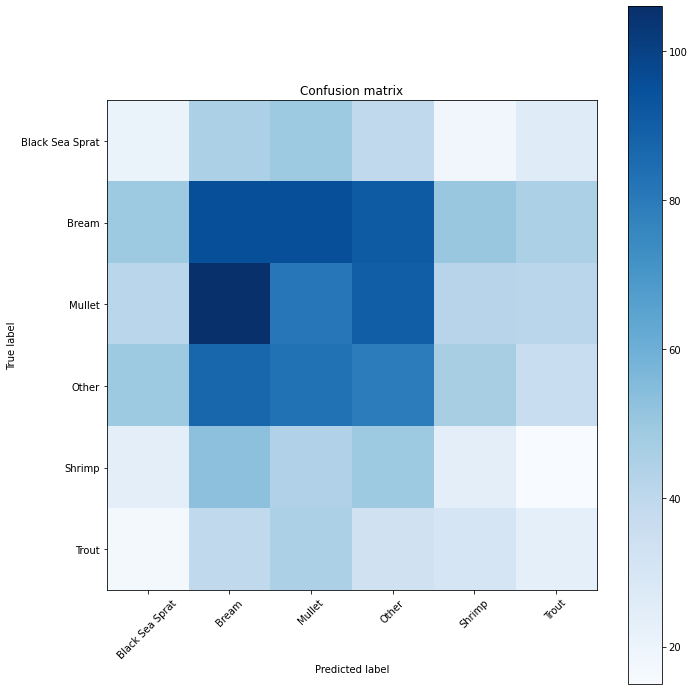

In [126]:
alt_y_pred_full = alt_model.predict(test_ds, batch_size=32)
alt_y_pred = np.argmax(alt_y_pred_full, axis=1)

alt_cm = tf.math.confusion_matrix(test_labels, alt_y_pred, num_classes=len(class_names))
print(alt_cm)
plot_confusion_matrix(alt_cm, class_names, title='Confusion matrix')

tf.Tensor(
[[  0   0 175  19   0   4]
 [  0   4 389  31   0   1]
 [  0   3 357  37   0   4]
 [  0   2 351  21   0   6]
 [  0   2 197   9   0   1]
 [  0   1 175  10   0   1]], shape=(6, 6), dtype=int32)


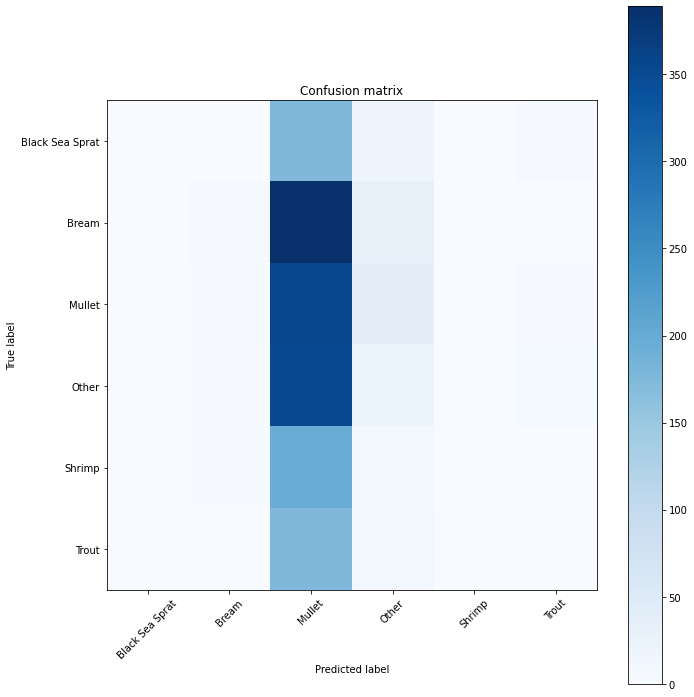

In [128]:
two_dense_y_pred_full = two_dense_model.predict(test_ds, batch_size=32)
two_dense_y_pred = np.argmax(two_dense_y_pred_full, axis=1)

two_dense_cm = tf.math.confusion_matrix(test_labels, two_dense_y_pred, num_classes=len(class_names))
print(two_dense_cm)
plot_confusion_matrix(two_dense_cm, class_names, title='Confusion matrix')

tf.Tensor(
[[ 24  40  48  46  18  22]
 [ 41 110 101  85  49  39]
 [ 36  97  76  92  56  44]
 [ 38  85  97  82  44  34]
 [ 29  49  42  40  23  26]
 [ 33  38  35  38  25  18]], shape=(6, 6), dtype=int32)


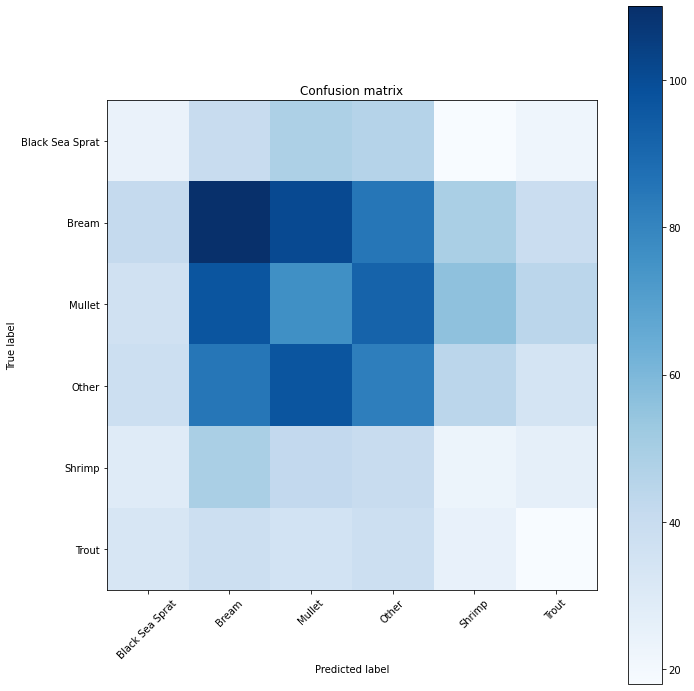

In [129]:
dropout_y_pred_full = dropout_model.predict(test_ds, batch_size=32)
dropout_y_pred = np.argmax(dropout_y_pred_full, axis=1)

dropout_cm = tf.math.confusion_matrix(test_labels, dropout_y_pred, num_classes=len(class_names))
print(dropout_cm)
plot_confusion_matrix(dropout_cm, class_names, title='Confusion matrix')

tf.Tensor(
[[29 52 42 47 16 12]
 [37 98 96 91 52 51]
 [47 94 82 79 53 46]
 [43 96 93 61 45 42]
 [25 47 51 37 30 19]
 [19 48 42 36 21 21]], shape=(6, 6), dtype=int32)


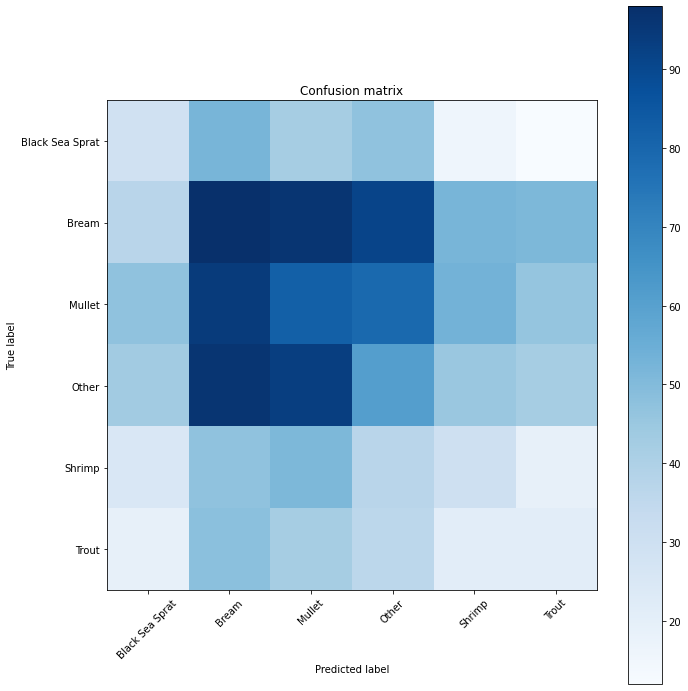

In [130]:
rescaling_y_pred_full = rescaling_model.predict(test_ds, batch_size=32)
rescaling_y_pred = np.argmax(rescaling_y_pred_full, axis=1)

rescaling_cm = tf.math.confusion_matrix(test_labels, rescaling_y_pred, num_classes=len(class_names))
print(rescaling_cm)
plot_confusion_matrix(rescaling_cm, class_names, title='Confusion matrix')